In [2]:
import statistics
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
np.random.seed(66)

In [3]:
fa_list = []
for x in range(2016, 2023):
    df = pd.read_csv('/Users/jarek/NBACSE163/' + str(x) + 'FA.csv')
    df['Contract_Year'] = x
    fa_list.append(df)
fa = pd.concat(fa_list, axis=0, ignore_index=True)
fa = fa[['Player', 'Contract_Year']]

In [4]:
stat_list = []
for x in range(2016, 2023):
    df = pd.read_csv('/Users/jarek/NBACSE163/' + str(x) + 'Stats.csv')
    df['Year'] = x
    stat_list.append(df)
stats = pd.concat(stat_list, axis=0, ignore_index=True)
stats.columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Player-additional', 'Year'],
      dtype='object')

In [5]:
final = pd.merge(fa, stats, on=['Player'], how='left')
final['PER'] = (final['FG'] * 85.910 + final['STL'] * 53.897 + final['3P'] * 51.757 + final['FT'] * 46.845
    + final['BLK'] * 39.190 + final['ORB'] * 39.190 + final['AST']* 34.677 + final['DRB'] * 14.707 - 2.5 * 17.174
    - (final['FTA'] - final['FT']) * 20.091 - (final['FGA'] - final['FG']) * 39.190 - final['TOV'] * 53.897 ) * (1 / final['MP'])
final = final.drop(['Rk', 'Pos', 'Tm', 'Player-additional'], axis=1)

In [6]:
before = (final['Contract_Year'] == final['Year'] + 1)
contract = (final['Contract_Year'] == final['Year'])
final = final[before | contract]

dups = final.duplicated(subset=['Player','Contract_Year'], keep=False)
final = final[dups]

final_shift = final.shift(-1)
def calc_avg_change(stat: str) -> float:
    diff = final_shift[stat] - final[stat]
    diff = diff.dropna()
    diff = diff.iloc[::2]
    return statistics.mean(diff)

avg_PER_change = calc_avg_change('PER')
avg_PTS_change = calc_avg_change('PTS')
avg_AST_change = calc_avg_change('AST')
avg_TRB_change = calc_avg_change('TRB')
print(avg_PTS_change, avg_AST_change, avg_TRB_change, avg_PER_change)

0.0974442988204456 0.010681520314547843 -0.012385321100917434 0.39496921687206943


In [9]:
PER_diff = final_shift['PER'] - final['PER']
PER_diff = PER_diff.dropna()
PER_diff = PER_diff.iloc[::2]

df = pd.merge(final, PER_diff, left_index=True, right_index=True)
df = df.rename(columns={'PER_x':'PER'})
df = df.rename(columns={'PER_y':'PER_diff'})
df = df.dropna()
test = df[df['PER_diff']>30]
test

,Player,Contract_Year,Age,G,GS,MP,FG,FGA,FG%,3P,...,TRB,AST,STL,BLK,TOV,PF,PTS,Year,PER,PER_diff
7247,Brian Bowen,2021,22.0,6.0,0.0,2.5,0.2,0.7,0.25,0.0,...,0.5,0.0,0.0,0.0,0.0,0.2,0.5,2021.0,-11.450200,33.807801
7347,Jared Harper,2021,23.0,8.0,0.0,2.0,0.0,0.5,0.00,0.0,...,0.3,0.1,0.0,0.0,0.4,0.1,0.4,2021.0,-29.740050,43.465917
8595,Jared Harper,2022,23.0,8.0,0.0,2.0,0.0,0.5,0.00,0.0,...,0.3,0.1,0.0,0.0,0.4,0.1,0.4,2021.0,-29.740050,68.688701
8736,Kyle Guy,2022,24.0,19.0,0.0,9.8,1.4,3.4,0.40,0.7,...,0.9,0.9,0.4,0.1,0.7,0.6,3.9,2022.0,8.877633,38.986367


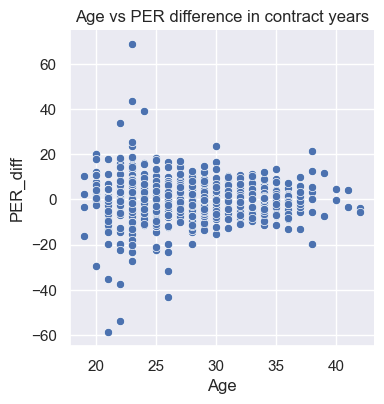

In [7]:
sns.relplot(
    data=df, x="Age", y="PER_diff", height=4,
)
plt.title("Age vs PER difference in contract years")
plt.show()

In [8]:
ml_df = df.drop(columns=['Player', 'Year', 'Contract_Year'])
features = ml_df.loc[:, ml_df.columns != 'PER']
labels = ml_df['PER']

In [10]:
features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.2)

In [11]:
model = DecisionTreeRegressor()
model.fit(features_train, labels_train)

train_predictions = model.predict(features_train)
print('Train MSE:', mean_squared_error(labels_train, train_predictions))

test_predictions = model.predict(features_test)
print('Test MSE:', mean_squared_error(labels_test, test_predictions))

Train MSE: 0.0
Test MSE: 9.415186035986219


In [12]:
m = RandomForestRegressor()
m.fit(features_train, labels_train)

train_predictions = m.predict(features_train)
print('Train MSE:', mean_squared_error(labels_train, train_predictions))

test_predictions = m.predict(features_test)
print('Test MSE:', mean_squared_error(labels_test, test_predictions))


Train MSE: 0.7674730696114758
Test MSE: 3.9865593355669517
